# example how to extract the S1/S2 features (maybe additional ECDC features) for reference point collections in openEO
In this example we look on each step to generate a ML usable training dataset from given reference points.

In [65]:
from eo_processing.utils.mgrs import get_MGRSid10_center
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import geojson
import openeo
from openeo.extra.job_management import MultiBackendJobManager, CsvJobDatabase
from eo_processing.utils.helper import init_connection
import numpy as np

### loading of the reference points CSV file as PANDAS dataframe
Note: this part has to be later adapted to be more adaptive to different input sources (GeoJSON, parquet files, STAC catalog, ...)

In [2]:
# Load the CSV file into a pandas dataframe
df = pd.read_csv(os.path.normpath(r'C:\Users\BUCHHORM\Downloads\SK_v5_reference-points_EUNIS2012.csv'))

### adding 10m GeoLocation identifier & cell center coordinates plus additional columns/checks
It is crucial that the reference data is in EPSG:4326 - identify the correct columns OR warp coordinates of other EPSG to EPSG:4326.

In [3]:
# first we add the unique MGRSid10 identifier and the corresponding center coordinates in EPSG:4326 for the 10m patch
df[['MGRSid10', 'center_lon', 'center_lat']] = df.apply(lambda row: get_MGRSid10_center(row['lon'], row['lat']), axis=1, result_type='expand')

In [4]:
# remove non-needed columns when exist
columns_to_remove = ['fid', 'entry', 'x', 'y']
df.drop(columns=[col for col in columns_to_remove if col in df.columns], inplace=True)

In [6]:
# Check and remove duplicate entries in the 'MGRSid10' column
if df['MGRSid10'].duplicated().any():
    duplicates = df[df['MGRSid10'].duplicated(keep=False)]
    print("Duplicate entries found in MGRSid10:")
    print(duplicates[['MGRSid10', 'lon', 'lat', 'center_lon', 'center_lat']])
    # Remove all entries with duplicate MGRSid10
    df = df[~df['MGRSid10'].duplicated(keep=False)]
    print("Duplicates have been removed.")
else:
    print("No duplicate entries in MGRSid10")

Duplicate entries found in MGRSid10:
            MGRSid10        lon        lat  center_lon  center_lat
324    39QTB31471177  48.448086  19.081292   48.448117   19.081264
325    39QTB31461179  48.448019  19.081471   48.448020   19.081444
326    39QTB31481179  48.448215  19.081411   48.448210   19.081446
328    39QTB31481179  48.448226  19.081406   48.448210   19.081446
330    39QTB31461181  48.447978  19.081629   48.448017   19.081624
...              ...        ...        ...         ...         ...
44731  38QRE13632584  47.951694  17.396612   47.951701   17.396584
44732  38QRE13622586  47.951573  17.396760   47.951610   17.396766
44733  38QRE13612585  47.951554  17.396698   47.951514   17.396678
44734  38QRE13642578  47.951783  17.396035   47.951786   17.396041
44735  38QRE13622586  47.951563  17.396732   47.951610   17.396766

[109 rows x 5 columns]
Duplicates have been removed.


In [7]:
# create a new column with the Sentinel-2 tileID
df['S2_tileID'] = df['MGRSid10'].astype(str).str[:5]

In [8]:
# reorder the columns just for better read
cols = df.columns.tolist()
new_order = ['MGRSid10', 'center_lon', 'center_lat', 'lon', 'lat', 'S2_tileID']
remaining_cols = [col for col in cols if col not in new_order]
df = df[new_order + remaining_cols]

### convert the DataFrame into a GeoPandas DataFrame with center point geometry

In [9]:
geometry = [Point(xy) for xy in zip(df.center_lon, df.center_lat)]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)
print(f'Number of reference points: {len(geo_df)}')

Number of reference points: 45140


### split the geodataframe by 100kgrid into stand-alone dataframes for job operation
the 100kgrid represent the Sentinel-2 tileIDs. That is needed to avoid openEO limitations for extraction


In [10]:
split_jobs = [geo_df[geo_df['S2_tileID'] == tile_id] for tile_id in geo_df['S2_tileID'].unique()]
print(f'Number of jobs: {len(split_jobs)}')

Number of jobs: 21


<Axes: >

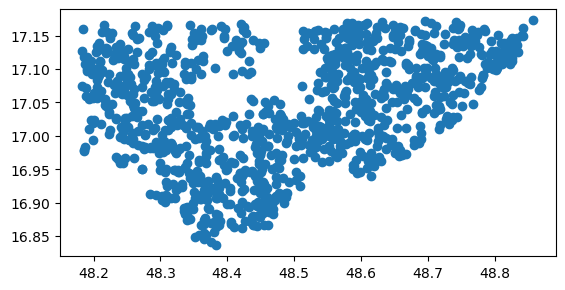

In [15]:
# for visualization we print all the points of one of the tiles (Sentinel-2 tileIDs)
split_jobs[0].geometry.plot()

### create the job dataframe with all info to run the openEO `MultiBackendJobManager` for the data extraction
For each job which has to run on openEO we need an extra row in a `pandas.DataFrame` which is handling all information needed by the JobManager to execute the `start_function`. The output dataframe should be savable as a .csv file. <br> <br>
Note: the full information of a sub-geodataframe of points/polygons can be saved into a row of a `pandas.DataFrame` by storing it in a row as string implementing the `geojson.FeatureCollection` interface. To convert the `geopandas.GeoDataFrame` into a string, simply use the `.to_json()` function.


In [16]:
def create_job_dataframe(split_jobs: list[gpd.GeoDataFrame], year: int, file_name_base: str) -> pd.DataFrame:
    """ Create a dataframe from the pre-split GeoDataFrame, containing all the necessary information to run the job.
    
    :param split_jobs: List of GeoDataFrames, each containing job information such as S2 tile ID and geometries.
    :param year: Year for which to create job entries. The start date will be January 1st of this year, and the end date will be January 1st of the following year.
    :param file_name_base: Base file name to be used, with the S2 tile ID appended to create unique file names for each job.
    :return: DataFrame containing job information, including the S2 tile ID, generated file name, start date, end date, and geometry as a JSON object.
    """
    
    columns = ['s2_tile', 'file_name', 'start_date', 'end_date', 'geometry']
    rows = []
    for job in split_jobs:
        # set master parameters
        start_date = f'{year}-01-01'
        end_date = f'{year+1}-01-01'
        s2_tile = job.S2_tileID.iloc[0]  # Job dataframes are split depending on the
        file_name = f'{file_name_base}_{s2_tile}.csv'
        
        rows.append(
            pd.Series(
                dict(zip(columns, [s2_tile, file_name, start_date, end_date, job.to_json()]))
            )
        )

    return pd.DataFrame(rows)

In [17]:
job_df = create_job_dataframe(split_jobs, 2021, 'SK_v5_reference-points_EUNIS2012_features')

In [28]:
# add the number of points to handle in each S2 tile
def get_point_number(row: pd.Series) -> int:
    """
    :param row: A pandas Series object that contains a geometry field with a GeoJSON string.
    :return: The number of features present in the GeoJSON geometry.
    """
    return len(geojson.loads(row.geometry)['features'])

job_df['n_points'] = job_df.apply(get_point_number, axis=1)

In [31]:
# NOTE: for processing time reduction we only process in this example the three shortest jobs
job_df_sub = job_df.nsmallest(3, 'n_points')

# Display the dataframe
print(job_df_sub)

   s2_tile                                          file_name  start_date  \
20   39QSC  SK_v5_reference-points_EUNIS2012_features_39QS...  2021-01-01   
15   39QSU  SK_v5_reference-points_EUNIS2012_features_39QS...  2021-01-01   
17   38QQE  SK_v5_reference-points_EUNIS2012_features_38QQ...  2021-01-01   

      end_date                                           geometry  n_points  
20  2022-01-01  {"type": "FeatureCollection", "features": [{"i...         3  
15  2022-01-01  {"type": "FeatureCollection", "features": [{"i...       128  
17  2022-01-01  {"type": "FeatureCollection", "features": [{"i...       279  


### creating the job `start_job` function
The next step is to define a `start_job` function. This function will instruct the `MultiBackendJobManager` on how to initiate a new job on the selected backend. The `start_job` functionality should adhere to the following structure _start_job(row: pd.Series, connection: openeo.Connection, **kwargs)_. <br> <br>
NOTE: for simplification in this example we will only extract the DEM value from the CDSE collection.

In [77]:
def point_extraction(row: pd.Series, connection: openeo.Connection, provider: str , **kwgs) -> openeo.BatchJob:
    """Start a new job using the specified row out of the jobs DataFrame and connection."""
    
    # Get the variable parameters from the dataframe
    tileID = row["s2_tile"]
    start = row["start_date"]
    end = row["end_date"]
    file_name = row["file_name"]
    
    #now we have to load the point geometries for all the points to process
    points_geometry = geojson.loads(row.geometry)
    assert isinstance(points_geometry, geojson.FeatureCollection)
    
    # Note: for points we do not define a spatial_extent in the collection at all AND run an aggregation_spatial with the GeoJSON FeatureCollection
    # Note2: for polygons we do not define a spatial_extent in the collection at all and later run a cube.filter_spatial(GeoJSON)
    DEM = connection.load_collection(
        "COPERNICUS_30",
        bands=["DEM"]
        )
    
    DEM = DEM.aggregate_spatial(points_geometry, reducer="first")
    
    job = DEM.create_job(title=os.path.splitext(file_name)[0], 
                         description=f'feature extraction for reference points in tile {tileID}', 
                         out_format='Parquet', 
                         filename_prefix=os.path.splitext(file_name)[0],
                         #sample_by_feature=True,
                         feature_id_property='MGRSid10'
                               )
    return job

### run the jobs

In [78]:
# define the output folder (make sure you adapt this to your folder structure)
test_num = 2
out_root = os.path.normpath(r'\\netapp03.vgt.vito.be\people_vol1\tests\openeo\point_extraction')
out_root = os.path.join(out_root, f'test_v{str(test_num)}')
os.makedirs(out_root, exist_ok=True)

In [79]:
# generate a unique name for the job tracker database (here: CSV file)
job_tracker = os.path.normpath(os.path.join(out_root, f'job_tracker_v{str(test_num)}.csv'))

In [37]:
# init of MultiBackendJobManager
manager = MultiBackendJobManager(root_dir=os.path.normpath(out_root), poll_sleep=20)

In [38]:
# create a connection to backend and add this active backend to the jobmanager
backend = 'cdse'  # also possible: cdse-stagging, terrascope, development, creodias, sentinelhub
connection = init_connection(backend)
manager.add_backend(backend, connection=connection, parallel_jobs=6)

Authenticated using refresh token.


In [80]:
# run the jobs stand-alone which blocks further usage of the Notebook up to all jobs are done
manager.run_jobs(df=job_df_sub, start_job=point_extraction, job_db=job_tracker)

In [ ]:
# add the costs to the tracker file
#todo